# Attendance Management System Using Computer Vision
---

Input: Security camera footage \
Output: Identity of students in the image 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image, ImageFilter
import math

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode, functional
from skimage import exposure

from skimage.transform import SimilarityTransform

### Get Information

Image shape: (1920, 1080)


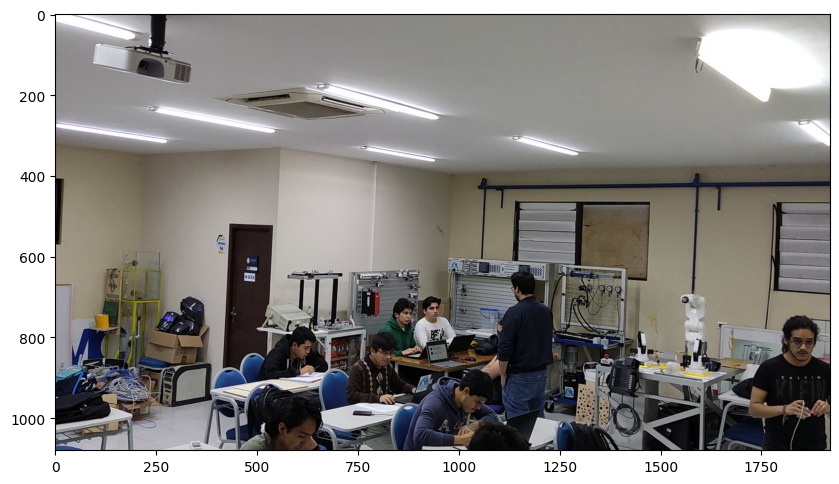

In [3]:
# Working with PIL Image
# --------------------------------
image = Image.open('../data/classroomUCB_cellphone/classroom0002.jpg')

plt.figure(figsize=[10,7]), plt.imshow(image)
print(f"Image shape: {image.size}")

## DATA PRE-PROCESSING
---

**1. Noise reduction:** \
The camera footage can contain different types of noises. Some filter can help reducing this noise, yet it is crucial to find out the type of noise. So real data must be analyzed.

**2. Brightness/Contrast Normalization:** \
Normalization of brightness/contrast can improve the visual clarity of the image, resulting in better results of the future facial recognition.

**3. Image Pyramid:** \
Before passing the photos to the MTCNN (Multi-task Cascaded Nueronal Networks) it is necessary to build pyramid of images with differents scales.

(<matplotlib.image.AxesImage at 0x1fe61292850>,
 Text(0.5, 1.0, 'Filtro pasa bajos'))

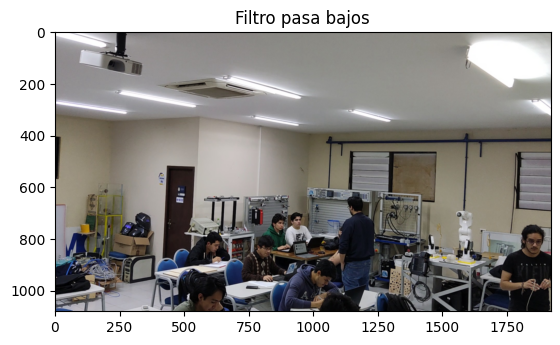

In [4]:
# FILTER -> Noise
# ----------------------------------------------------------

imgCopy = image.copy()

# Define filter for the image (OpenCV)
# noiseFilter = lambda x: cv2.medianBlur(x, ksize=1)
# transformNoiseFilter = transforms.Lambda(noiseFilter)

# Define filter (PIL)
kernel = [
    1, 1, 1,
    1, 1, 1,
    1, 1, 1
] 
normKernel = [value / sum(kernel) for value in kernel]

filtro = ImageFilter.Kernel((3,3), normKernel)
transFilter = lambda x: x.filter(filtro)
transNoiseFilter = transforms.Lambda(transFilter)

filteredImg = transNoiseFilter(imgCopy)

# plt.figure(figsize=[20, 15]), plt.subplot(1,2,1)
# plt.subplot(121), plt.imshow(image), plt.title("Original Image")
# plt.subplot(122), plt.imshow(filteredImg), plt.title("Filtered Image")


plt.imshow(filteredImg), plt.title("Filtro pasa bajos")


(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Normalizacion de contraste'))

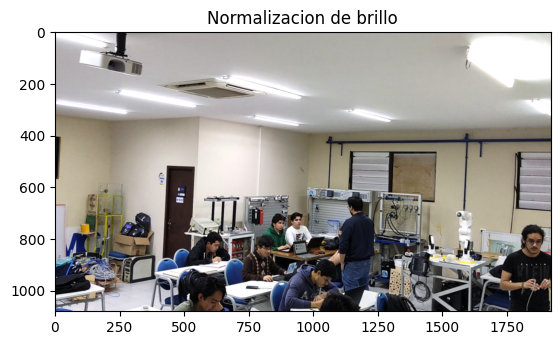

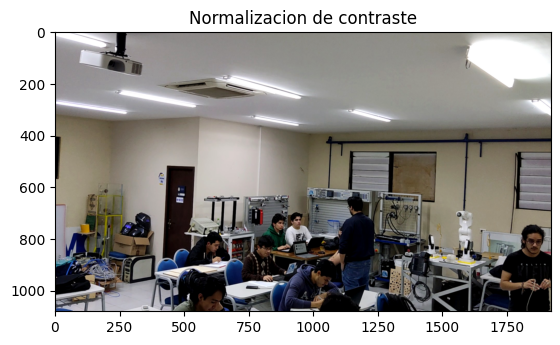

In [5]:
# Brigthness/Contrast Normalization 
# -----------------------------------------------

import torchvision.transforms as transforms

# Brightness normalization 
brightnessScale = 1.25
transBrightness = lambda img: transforms.functional.adjust_brightness(img, brightnessScale)

# Contrast Normalization 
contrastScale = 1.07
transConstrast = lambda img: transforms.functional.adjust_contrast(img, contrastScale)


# Apply transformations
img_B = transBrightness(filteredImg)
img_C = transConstrast(filteredImg)

preprocessImage = transConstrast(img_C)

# Compare results 
# plt.figure(figsize=[15,10]), plt.subplot(221)
# plt.subplot(221), plt.imshow(img_B), plt.title("Brightness Normalization")
# plt.subplot(222), plt.imshow(img_C), plt.title("Contrast Normalization")
# plt.subplot(223), plt.imshow(image), plt.title("Original Image")
# plt.subplot(224), plt.imshow(preprocessImage), plt.title("Brightness + Contrast Normalization")

# Separate Image 
plt.figure(), plt.imshow(img_B), plt.title("Normalizacion de brillo")
plt.figure(), plt.imshow(preprocessImage), plt.title("Normalizacion de contraste")

In [6]:
def MTCNN_preprocessing(image): 
    """
    Pre-process the data to use it in the MTCNN
    
    Args: 
        image: PIL.Image
    Returns: 
        preProcessimage: torch.Tensor
    """
    # LOW PASS FILTER 
    # ------------------------------------------
    kernel = [
        1, 1, 1,
        1, 1, 1,
        1, 1, 1
    ] 
    normKernel = [value / sum(kernel) for value in kernel]

    filtro = ImageFilter.Kernel((3,3), normKernel)
    transFilter = lambda x: x.filter(filtro)
    transFilter = lambda x: x

    # BRIGHTNESS NORMALIZATION 
    # -------------------------------------------
    brightnessScale = 1.1
    transBrightness = lambda img: functional.adjust_brightness(img, brightnessScale)

    # CONTRAST NORMALIZATION
    # -------------------------------------------
    contrastScale = 1.1
    transConstrast = lambda img: functional.adjust_contrast(img, contrastScale)

    # FROM TENSOR TO PIL IMAGE
    # -------------------------------------------
    tensor2PIL = lambda img: functional.to_pil_image(img)

    # FROM PIL IMAGE TO TENSOR
    # -------------------------------------------
    PIL2Tensor = lambda img: functional.pil_to_tensor(img)
    
    camera_transforms = transforms.Compose([transforms.Lambda(transFilter),
                                            transforms.Lambda(transBrightness),
                                            transforms.Lambda(transConstrast),
                                            transforms.Lambda(PIL2Tensor)])


    preProcessImg = camera_transforms(image)

    return preProcessImg
    

Type: <class 'torch.Tensor'> | Valor Maximo: 255 | Valor Minimo: 0 | Media: 127.53899383544922 | Varianza: 4571.24462890625


(<matplotlib.image.AxesImage at 0x1fe61f2a850>,
 Text(0.5, 1.0, 'Image Pre-MTCNN'))

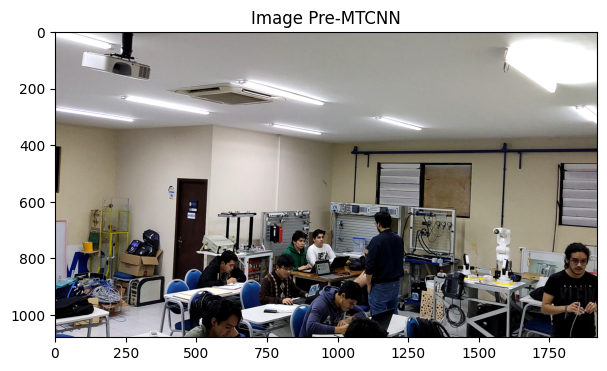

In [7]:
test_img = MTCNN_preprocessing(image)

print(f"Type: {type(test_img)} | Valor Maximo: {torch.max(test_img)} | Valor Minimo: {torch.min(test_img)} | Media: {torch.mean(test_img.float())} | Varianza: {torch.var(test_img.float())}")

# Show result 
plt.figure(figsize=[7,5])
plt.imshow(test_img.permute(1,2,0).numpy()), plt.title("Image Pre-MTCNN")

# MTCNN (Multi-task Cascaded Convolutional Networks)
---
The MTCNN is used to detect all the faces present in the image

In [8]:
# Testing with an already implemented MTCNN
from mtcnn import MTCNN

In [9]:
def detectFaces(image): 
    """
    Detect faces using MTCNN model
    Args: 
        image: Tensor
    Output: 
        faces: list of np.arrays() of detected faces
    """

    # Detect the faces
    detector = MTCNN()
    faces = detector.detect_faces(image.permute(1,2,0).numpy())

    print(f"Faces found with original image: {len(faces)}")
    
    return faces

In [10]:
detector = MTCNN()

faces = detector.detect_faces(test_img.permute(1,2,0).numpy())

print(f"Faces found {len(faces)}")

3/3 [==============================] - 0s 13ms/step
Faces found 6


### Pre-processing before sending the data to the server 

**1. Recorte de rostros:**\
Se extraen en imagenes separadas las areas de interes (donde existen rostros) \
**2. Alineacion de rostros:** \
Se alinean los rostros extraidos para una comparacion mas precisa. Se alinean utilizando 5 facial points y utilizando transformaciones geometricas se los alinean. \
**3. Mejora del contraste:** \
Para resaltar caracteristicas faciales (Ecualizacion adaptiva de histograma) 

In [13]:
def getFacialPtos(facesData):
    """
    Extract list of facial points corresponding to each detected face
    Args: 
        facesData: dict containing {'box', 'keypoints', 'confidence'}
    Output: 
        facialPtos: list of facial landmarks
    """
    
    facialPtos = []
    
    for i in range(len(facesData)): 
        
        # Get all keypoints
        keypoints = facesData[i].get('keypoints')
        print(keypoints)

        # Get all facial landmarks respeting to the bbox of each face
        left_eye = np.array(keypoints.get('left_eye')) 
        right_eye = np.array(keypoints.get('right_eye'))
        nose = np.array(keypoints.get('nose'))
        mouth_left = np.array(keypoints.get('mouth_left'))
        mouth_right = np.array(keypoints.get('mouth_right'))

        facialPtos.append(np.array([left_eye, right_eye, nose, mouth_left, mouth_right], dtype=np.float32))
    
    return facialPtos


In [14]:
def preprocessFaces(image, bbox, facialLandmarks = None): 
    """
    This function crops the detected faces of the image and resize them to a standard value
    Args: 
        image: Tensor with shape (3,W,H)
        bbox: List of tuples (y,x,h,w) indicating bounding boxes locations
    Returns:
        detected_faces: List of Tensor images of 
    """
    
    # Define the output size of the Image (256x256) 
    # -> Based on the input value of the CNN use for feature extraction (MobileNet)
    reescale = transforms.Resize((256,256), interpolation=InterpolationMode.BICUBIC)
    
    # Crop the faces and saved them in a list
    detected_faces = []
    for i in range(len(bbox)): 
        # Crop the face of the image
        face = transforms.functional.crop(img=Image.fromarray(image), 
                                          top=bbox[i][1], left=bbox[i][0], height=bbox[i][3], width=bbox[i][2])
        # Sclaed the image to the standard value
        face = reescale.forward(face)
        # Rotate the faces to align the facial landmarks (Not done yet)
#         face = alignFace(face, facialLandmarks[i])
        
        
        detected_faces.append(face)
        
    return detected_faces

87 118
168 117
128 163
94 211
161 210


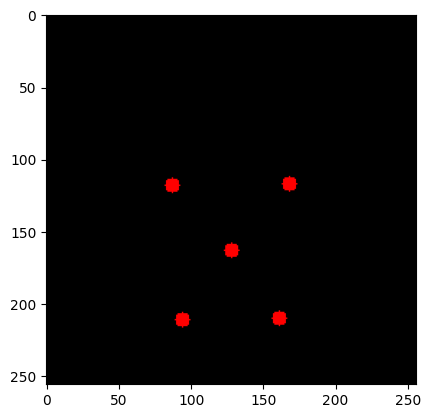

In [15]:
black_image = np.zeros((256, 256, 3), dtype=np.uint8)
plt.imshow(black_image)

facial = np.array([
            [38.2946, 51.6963],
            [73.5318, 51.5014],
            [56.0252, 71.7366],
            [41.5493, 92.3655],
            [70.7299, 92.2041]
        ], dtype=np.float32) / 112


for i in range(len(facial)): 
    x = int(facial[i][0] * 256)
    y = int(facial[i][1] * 256)
    print(x,y)
    black_image = cv2.circle(black_image, (x,y) , 5, (255,0,0), -1)
    
plt.imshow(black_image)

In [16]:
def align_face(img: np.ndarray, src: np.array, dst: np.array = None, dsize: tuple=None):
    """
    Alignment of a face given the source and target landmarks
    
    Args: 
        img: image of any size and any type
        src: landmarks of the source image 
        dst: landmarks for the target image
    Outputs: 
        image with size dsize and same type as img
    """
    
    # Relative target landmarks for alignment
    landmarks = {
        "mtcnn": np.array(
        [
            [38.2946, 51.6963],
            [73.5318, 51.5014],
            [56.0252, 71.7366],
            [41.5493, 92.3655],
            [70.7299, 92.2041],
        ],
            dtype=np.float32,)
        / 112,
    }


    # Convert img to np.array()
    if not isinstance(img, np.ndarray):

        if isinstance(img, Image.Image):
            img = np.array(img)

        if isinstance(img, torch.Tensor):
            img = img.permute(1,2,0).numpy()


    
    if dst is None: 
        dst = landmarks.get('mtcnn')
    
    if dsize is None: 
        dsize = img.shape[:2][::-1]
    
    assert src.shape == (5,2), "Wrong shape of source landmarks"
    assert dst.shape == (5,2), "Wrong shape of destination landmarks"
    
    tform = SimilarityTransform()
    tform.estimate(src, dst*dsize)
    
    t_matrix = SimilarityTransform()
    t_matrix.estimate(src, dst*dsize)
    
    return cv2.warpAffine(img, t_matrix.params[0:2, :], dsize)
    

3/3 [==============================] - 0s 22ms/step
Faces found with original image: 8
{'left_eye': (1170, 481), 'right_eye': (1182, 482), 'nose': (1181, 491), 'mouth_left': (1170, 499), 'mouth_right': (1180, 499)}
{'left_eye': (1241, 476), 'right_eye': (1255, 475), 'nose': (1252, 485), 'mouth_left': (1242, 493), 'mouth_right': (1254, 492)}
{'left_eye': (934, 570), 'right_eye': (945, 572), 'nose': (943, 583), 'mouth_left': (930, 588), 'mouth_right': (939, 589)}
{'left_eye': (105, 590), 'right_eye': (133, 586), 'nose': (123, 604), 'mouth_left': (112, 619), 'mouth_right': (134, 616)}
{'left_eye': (1487, 852), 'right_eye': (1511, 857), 'nose': (1507, 880), 'mouth_left': (1472, 896), 'mouth_right': (1493, 899)}
{'left_eye': (966, 773), 'right_eye': (991, 780), 'nose': (981, 797), 'mouth_left': (953, 806), 'mouth_right': (975, 811)}
{'left_eye': (1148, 578), 'right_eye': (1158, 577), 'nose': (1161, 587), 'mouth_left': (1149, 598), 'mouth_right': (1157, 597)}
{'left_eye': (1379, 695), 'right

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Face aligned using 5 facial points'))

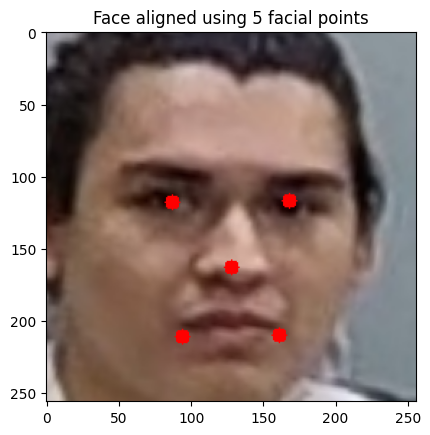

In [17]:
# VISUALIZE ALIGNED FACE
# ---------------------------

# Read Image 
image = Image.open('../data/classroomUCB_cellphone/classroom0326.jpg')
img = functional.pil_to_tensor(image)

# Detect Faces 
faces = detectFaces(img)

# Extract facial points
facialPtos = getFacialPtos(faces)

# Get one aligned face
alignFace = align_face(img, facialPtos[3], dsize=np.array([256,256]))

# Show facial points
facial = np.array([
            [38.2946, 51.6963],
            [73.5318, 51.5014],
            [56.0252, 71.7366],
            [41.5493, 92.3655],
            [70.7299, 92.2041]
        ], dtype=np.float32) / 112


for i in range(len(facial)): 
    x = int(facial[i][0] * 256)
    y = int(facial[i][1] * 256)
    print(x,y)
    cv2.circle(alignFace, (x,y) , 5, (255,0,0), -1)

# Show final result
# plt.figure(figsize=[10,7])
# plt.subplot(121), plt.imshow(image), plt.title("Original Image")
# plt.subplot(122), plt.imshow(alignFace), plt.title("Face aligned using 5 facial points")

plt.figure(), plt.imshow(alignFace), plt.title("Face aligned using 5 facial points")

In [18]:
def alignAllFaces(img: np.ndarray, src: np.array, dst: np.array = None, dsize: tuple=None):

    alignFaces = []

    for i in range(len(src)):
        alignFace = align_face(img, src[i], dst, dsize)
        alignFaces.append(alignFace)

    return alignFaces

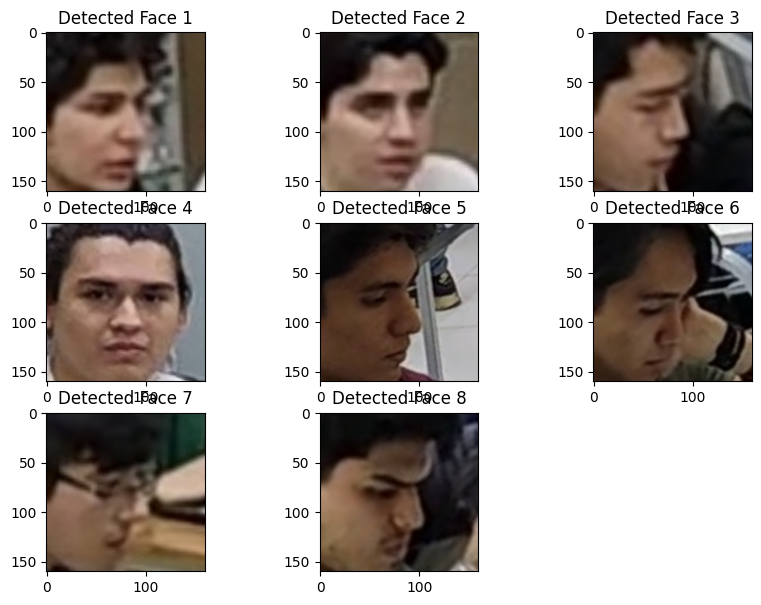

In [19]:
allAlignFaces = alignAllFaces(img=img, src=facialPtos, dsize=np.array([160,160]))

rows = int(np.ceil(len(allAlignFaces)/3))
plt.figure(figsize=[10,7])

for i in range(len(allAlignFaces)):
    plt.subplot(rows, 3, i+1), plt.imshow(allAlignFaces[i])
    plt.title(f"Detected Face {i+1}")

In [21]:
# HISTROGRAM EQUALIZATION FOR ALIGNED FACES
  
def histrogramEqualization(image):
    """
    Do histrogram equalization maintaining all 3 RGB channels 
    Args: 
        image(PIL.Image): 
    Outputs:
        eq_img(PIL.Image):
    """
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    eq_img = exposure.equalize_hist(image)

    return eq_img
    

(<Figure size 700x500 with 1 Axes>,
 Text(0.5, 1.0, 'Equalized Image'))

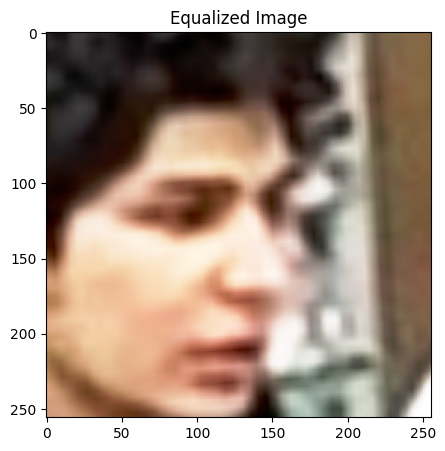

In [26]:
# Get one aligned face
histTest = align_face(img, facialPtos[0], dsize=np.array([256,256]))
histImg = histrogramEqualization(histTest)

# plt.figure(figsize=[10,7])
# plt.subplot(121), plt.imshow(histTest), plt.title("Not Equalized Image")
# plt.subplot(122), plt.imshow(histImg), plt.title("Equalized Image")

plt.figure(figsize=[7,5]), plt.imshow(histImg), plt.title("Equalized Image")
